# Alarm Logs in Packaging Industry (ALPI)

## Load the dataset

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Dataset source: https://ieee-dataport.org/open-access/alarm-logs-packaging-industry-alpi

In [2]:
data_path = "../data/alarms-log-data/raw/alarms.csv"
df = pd.read_csv(data_path)
df["timestamp"] = pd.to_datetime(df["timestamp"])

display(df.head())
print("Num. rows:", len(df))

,timestamp,alarm,serial
0,2019-02-21 19:57:57.532,139,4
1,2019-02-21 19:58:28.293,139,4
2,2019-02-21 19:58:32.853,139,4
3,2019-02-21 19:59:05.387,139,4
4,2019-02-21 20:02:05.832,139,4


Num. rows: 444834


## Simple EDA

In [137]:
machines = df["serial"].value_counts()
machines = pd.DataFrame(machines)
machines = machines.sort_values(by=["serial"])
# machines.head()

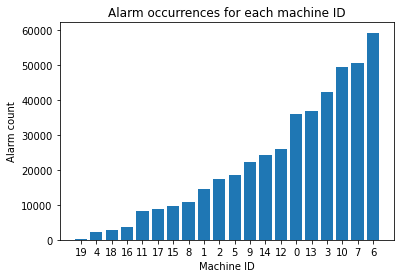

In [138]:
machine_ids = list(map(lambda x: str(x), machines.index))

plt.bar(machine_ids, machines.serial)
plt.title("Alarm occurrences for each machine ID")
plt.xlabel("Machine ID")
plt.ylabel("Alarm count")
plt.show()

In [139]:
alarms = df["alarm"].value_counts()
alarms = pd.DataFrame(alarms)
alarms = alarms.sort_values(by=["alarm"])
# alarms.head()

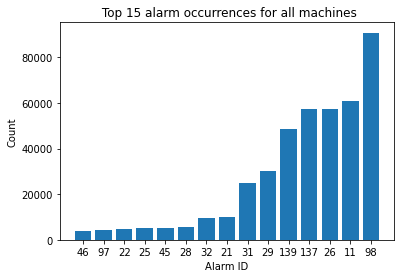

In [140]:
alarm_ids = list(map(lambda x: str(x), alarms.index))

top_n = 15
plt.bar(alarm_ids[-top_n:], alarms.alarm[-top_n:])
plt.title(f" Top {top_n} alarm occurrences for all machines")
plt.xlabel("Alarm ID")
plt.ylabel("Count")
plt.show()

## Encode the alarm occurences

In [5]:
def get_alarm_occurences(dataset, machine_id, month, year):
    result = dataset[
        (dataset["serial"] == machine_id) 
        & (dataset["timestamp"].dt.month == month) 
        & (dataset["timestamp"].dt.year == year)
    ]
    result = result.drop("serial", axis=1)
    result = result.set_index(["timestamp"])
    result = result.astype(str)
    return result

def transform_dataset(dataset):
    """Transform dataset using one hot encoder"""
    return pd.get_dummies(dataset, prefix=['alarm']).resample("15min").sum()


In [11]:
year_month = {
    "2019": {
        "year": 2019,
        "months": list(range(1, 12+1))
    },
    "2020": {
        "year": 2020,
        "months": list(range(1, 12+1))
    }
}

display(year_month)

{'2019': {'year': 2019, 'months': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]},
 '2020': {'year': 2020, 'months': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}}

In [18]:
data_path = "../data/alarms-log-data/processed/encoded/"

for machine_id in df["serial"].unique():
    print("Processing data for the machine #", machine_id)

    result_dict = {}
    
    for key, item in year_month.items():
        year = item["year"]
        for month in item["months"]:
            result = get_alarm_occurences(df, machine_id, month, year)
            result = transform_dataset(result)
            m = f"{month}" if month>=10 else f"0{month}" 
            result_dict[f"{year}_{m}"] = result
        
    encoded_data = []

    for k, item in result_dict.items():
        if item.empty is not True:
            encoded_data.append(item)

    encoded_data = pd.concat(encoded_data, axis=0)\
        .fillna(0)\
        .astype("float32")
    
    file_name = data_path + "csv/" + f"machine-{machine_id}-encoded-alarms.csv"
    encoded_data.to_csv(file_name, index=True)

    file_name = data_path + "parquet/" + f"machine-{machine_id}-encoded-alarms.parquet.gzip"
    encoded_data.to_parquet(file_name, compression="gzip", index=True)

Processing data for the machine # 4
Processing data for the machine # 13
Processing data for the machine # 3
Processing data for the machine # 5
Processing data for the machine # 8
Processing data for the machine # 14
Processing data for the machine # 10
Processing data for the machine # 15
Processing data for the machine # 16
Processing data for the machine # 6
Processing data for the machine # 2
Processing data for the machine # 1
Processing data for the machine # 7
Processing data for the machine # 9
Processing data for the machine # 0
Processing data for the machine # 12
Processing data for the machine # 17
Processing data for the machine # 11
Processing data for the machine # 18
Processing data for the machine # 19


## Read one of the saved files and do a simple EDA

In [56]:
file_path = data_path + "csv/" + f"machine-4-encoded-alarms.csv"
machine4_encoded = pd.read_csv(file_path, index_col="timestamp")
machine4_encoded

,alarm_139,alarm_26,alarm_27,alarm_29,alarm_51,alarm_98,alarm_1,alarm_111,alarm_12,alarm_131,...,alarm_46,alarm_17,alarm_25,alarm_34,alarm_55,alarm_0,alarm_37,alarm_48,alarm_32,alarm_79
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-02-21 19:45:00,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-21 20:00:00,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-21 20:15:00,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-21 20:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-21 20:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-16 14:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-06-16 14:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-06-16 14:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


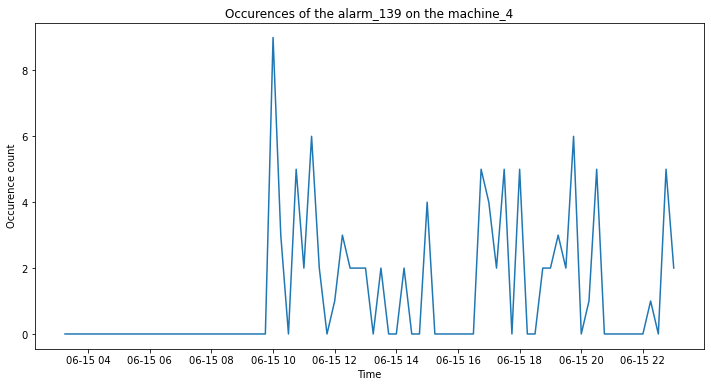

In [57]:
machine_id = 4
alarm_id = "alarm_139"

plt_1 = plt.figure(figsize=(12, 6))
plt.plot(machine4_transformed.index[-80:], machine4_transformed[alarm_id][-80:])

plt.title(f"Occurences of the {alarm_id} on the machine_{machine_id}")
plt.xlabel("Time")
plt.ylabel("Occurence count")
plt.show()